In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"phoenix1202","key":"ef6d11f6339bb63a89c8d4bfedcbf481"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
from google.colab import drive
drive.mount('/content/drive')
!kaggle datasets download -d jutrera/stanford-car-dataset-by-classes-folder
!unzip stanford-car-dataset-by-classes-folder.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: car_data/car_data/train/Chrysler Aspen SUV 2009/04381.jpg  
  inflating: car_data/car_data/train/Chrysler Aspen SUV 2009/04688.jpg  
  inflating: car_data/car_data/train/Chrysler Aspen SUV 2009/04772.jpg  
  inflating: car_data/car_data/train/Chrysler Aspen SUV 2009/05544.jpg  
  inflating: car_data/car_data/train/Chrysler Aspen SUV 2009/05728.jpg  
  inflating: car_data/car_data/train/Chrysler Aspen SUV 2009/05860.jpg  
  inflating: car_data/car_data/train/Chrysler Aspen SUV 2009/06146.jpg  
  inflating: car_data/car_data/train/Chrysler Aspen SUV 2009/06157.jpg  
  inflating: car_data/car_data/train/Chrysler Aspen SUV 2009/06332.jpg  
  inflating: car_data/car_data/train/Chrysler Aspen SUV 2009/06441.jpg  
  inflating: car_data/car_data/train/Chrysler Aspen SUV 2009/06447.jpg  
  inflating: car_data/car_data/train/Chrysler Aspen SUV 2009/06590.jpg  
  inflating: car_data/car_data/train/Chrysler Aspen SUV 

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math

from sklearn import metrics
from tqdm.auto import tqdm
from torchvision import datasets, transforms
from torchvision import models
from PIL import Image
from collections import OrderedDict
from typing import Any, List, Tuple
from torch import Tensor

import matplotlib.pyplot as plt

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_path = "./car_data/car_data/"
NUM_CLASSES = 196

In [9]:
class MyClassifier(nn.Module):
    def __init__(self, model, model_name):
        super().__init__()
        self.model = model
        self.model.to(device)
        self.model_name = model_name

    def train_model(self, dataloaders, image_datasets, criterion, optimizer, num_epochs=50):
        for epoch in range(num_epochs):
            print('Epoch {}/{}'.format(epoch + 1, num_epochs))
            print('-' * 10)

            for phase in ['train', 'test']:
                if phase == 'train':
                    self.model.train()
                else:
                    self.model.eval()

                running_loss = 0.0
                running_corrects = 0

                y_test = []
                y_pred = []
                for inputs, labels in tqdm(dataloaders[phase]):
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    outputs = self.model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                    _, preds = torch.max(outputs, 1)
                    y_test.extend(labels)
                    y_pred.extend(preds)
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                epoch_loss = running_loss / len(image_datasets[phase])
                epoch_acc = running_corrects / len(image_datasets[phase])

                with open('./drive/MyDrive/Colab_Notebooks/' + self.model_name + '_epoch_res.txt', 'a') as f:
                    f.write('{} loss: {:.4f}, acc: {:.4f}\n'.format(phase,
                                                                    epoch_loss,
                                                                    epoch_acc))
                print('{} loss: {:.4f}, acc: {:.4f}\n'.format(phase,
                                                              epoch_loss,
                                                              epoch_acc))
                torch.save(self.model.state_dict(), './drive/MyDrive/Colab_Notebooks/densenet_radam_weights_{}.h5'.format(epoch))
        return self.model

In [43]:
class DenseNet(nn.Module):

    def __init__(
            self,
            block_cfg: Tuple[int, int, int, int] = (6, 12, 24, 16),
            channels: int = 64,
            growth_rate: int = 32,
            bottle_neck_size: int = 4,
            dropout_rate: float = 0.0,
            num_classes: int = 1000,
    ):
        super(DenseNet, self).__init__()
        self.features = nn.Sequential(
            OrderedDict(
                [
                    ("conv0", nn.Conv2d(3, channels, (7, 7), (2, 2), (3, 3), bias=False)),
                    ("norm0", nn.BatchNorm2d(channels)),
                    ("relu0", nn.ReLU(True)),
                    ("pool0", nn.MaxPool2d((3, 3), (2, 2), (1, 1))),
                ]
            )
        )

        for i, repeat_times in enumerate(block_cfg):
            block = _DenseBlock(
                repeat_times=repeat_times,
                channels=channels,
                growth_rate=growth_rate,
                bottle_neck_size=bottle_neck_size,
                dropout_rate=dropout_rate,
            )
            self.features.add_module(f"denseblock{i + 1}", block)
            channels = channels + int(repeat_times * growth_rate)
            if i != len(block_cfg) - 1:
                trans = _Transition(channels, channels // 2)
                self.features.add_module(f"transition{i + 1}", trans)
                channels = channels // 2

        self.features.add_module("norm5", nn.BatchNorm2d(channels))
        self.features.add_module("relu5", nn.ReLU(True))
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(channels, num_classes)
        self._initialize_weights()

    def _initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.kaiming_normal_(module.weight)
            elif isinstance(module, nn.BatchNorm2d):
                nn.init.constant_(module.weight, 1)
                nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.Linear):
                nn.init.constant_(module.bias, 0)

    def forward(self, x: Tensor):
        out = self.features(x).to(device)
        out = self.avgpool(out).to(device)
        out = torch.flatten(out, 1).to(device)
        out = self.classifier(out).to(device)
        return out


class _DenseLayer(nn.Module):
    def __init__(
            self,
            channels: int,
            growth_rate: int,
            bottle_neck_size: int,
            dropout_rate: float,
    ):
        super(_DenseLayer, self).__init__()
        growth_channels = int(bottle_neck_size * growth_rate)
        self.dropout_rate = float(dropout_rate)

        self.norm1 = nn.BatchNorm2d(channels)
        self.relu1 = nn.ReLU(True)
        self.conv1 = nn.Conv2d(channels, growth_channels, (1, 1), (1, 1), (0, 0), bias=False)

        self.norm2 = nn.BatchNorm2d(growth_channels)
        self.relu2 = nn.ReLU(True)
        self.conv2 = nn.Conv2d(growth_channels, growth_rate, (3, 3), (1, 1), (1, 1), bias=False)
        self.dropout = nn.Dropout(dropout_rate, True)

    def forward(self, x: List[Tensor]):
        out = torch.cat(x, 1).to(device)
        out = self.norm1(out).to(device)
        out = self.relu1(out).to(device)
        out = self.conv1(out).to(device)
        out = self.norm2(out).to(device)
        out = self.relu2(out).to(device)
        out = self.conv2(out).to(device)
        if self.dropout_rate > 0:
            out = self.dropout(out).to(device)
        return out


class _DenseBlock(nn.ModuleDict):
    def __init__(
            self,
            repeat_times: int,
            channels: int,
            growth_rate: int,
            bottle_neck_size: int,
            dropout_rate: float,
    ):
        super(_DenseBlock, self).__init__()
        for i in range(repeat_times):
            layer = _DenseLayer(
                channels=channels + i * growth_rate,
                growth_rate=growth_rate,
                bottle_neck_size=bottle_neck_size,
                dropout_rate=dropout_rate,
            )
            self.add_module(f"denselayer{i + 1}", layer)

    def forward(self, x: List[Tensor]):
        out = [x]
        for _, layer in self.items():
            denselayer_out = layer(out).to(device)
            out.append(denselayer_out)
        out = torch.cat(out, 1).to(device)
        return out


class _Transition(nn.Sequential):
    def __init__(
            self,
            in_channels: int,
            out_channels: int,
    ):
        super(_Transition, self).__init__()
        self.norm = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(True)
        self.conv = nn.Conv2d(in_channels, out_channels, (1, 1), (1, 1), (0, 0), bias=False)
        self.pool = nn.AvgPool2d((2, 2), (2, 2))


def densenet121():
    model = DenseNet((6, 12, 24, 16), 64, 32, num_classes=NUM_CLASSES)
    return model


def densenet161():
    model = DenseNet((6, 12, 36, 24), 96, 48, num_classes=NUM_CLASSES)
    return model


def densenet169():
    model = DenseNet((6, 12, 32, 32), 64, 32, num_classes=NUM_CLASSES)
    return model


def densenet201():
    model = DenseNet((6, 12, 48, 32), 64, 32, num_classes=NUM_CLASSES)
    return model

In [44]:
class Solver:
    def __init__(self):
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
        self.data_transforms = {
            'train':
                transforms.Compose([
                    transforms.Resize((224, 224)),
                    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    self.normalize
                ]),
            'test':
                transforms.Compose([
                    transforms.Resize((224, 224)),
                    transforms.ToTensor(),
                    self.normalize
                ]),
        }

        self.image_datasets = {
            'train':
                datasets.ImageFolder(input_path + 'train', self.data_transforms['train']),
            'test':
                datasets.ImageFolder(input_path + 'test', self.data_transforms['test'])
        }

        self.dataloaders = {
            'train':
                torch.utils.data.DataLoader(self.image_datasets['train'],
                                            batch_size=32,
                                            shuffle=True,
                                            num_workers=0),
            'test':
                torch.utils.data.DataLoader(self.image_datasets['test'],
                                            batch_size=32,
                                            shuffle=False,
                                            num_workers=0)
        }

    def train(self):
        # with Adam optimizer
        densenet = MyClassifier(densenet121(), "densenet121_adam")
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(densenet.model.parameters())
        trained_densenet = densenet.train_model(self.dataloaders, self.image_datasets, criterion, optimizer, 50)
        torch.save(trained_densenet.state_dict(), 'densenet121_adam_weights.h5')

        # with RAdam optimizer
        densenet = MyClassifier(densenet121(), "densenet121_radam")
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.RAdam(densenet.model.parameters())
        trained_densenet = densenet.train_model(self.dataloaders, self.image_datasets, criterion, optimizer, 50)
        torch.save(trained_densenet.state_dict(), 'densenet121_radam_weights.h5')

    def test_model(self, name, opt):
        print(name, opt)
        if name == "densenet121":
            cur_model = densenet121()
        elif name == "densenet161":
            cur_model = densenet161()
        elif name == "densenet169":
            cur_model = densenet169()
        else:
            cur_model = densenet201()
        trained_model = cur_model.to(device)
        trained_model.load_state_dict(torch.load("./drive/MyDrive/Colab_Notebooks/" + name + "_" + opt + "_weights.h5", map_location=device))

        validation_img_paths = ["test/Audi 100 Sedan 1994/00333.jpg",
                                "test/HUMMER H2 SUT Crew Cab 2009/00517.jpg",
                                "test/Ferrari California Convertible 2012/00666.jpg"]
        img_list = [Image.open(input_path + img_path) for img_path in validation_img_paths]

        validation_batch = torch.stack([self.data_transforms['test'](img).to(device)
                                        for img in img_list]).to(device)

        pred_logits_tensor = trained_model(validation_batch)

        pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()

        for i, img in enumerate(img_list):
            ans = []
            for x in pred_probs[i]:
                ans.append(math.floor(x * 100))
            print(ans)
            print("{:.0f}% Audi, {:.0f}% Hummer, {:.0f}% Ferrari".format(100 * pred_probs[i, 11],
                                                                         100 * pred_probs[i, 123],
                                                                         100 * pred_probs[i, 102]))

    def test(self):
        self.test_model("densenet121", "adam")
        self.test_model("densenet121", "radam")

In [ ]:
!chmod 777 ./drive/MyDrive/Colab_Notebooks/densenet_radam_weights.h5
!chmod 777 ./drive/MyDrive/Colab_Notebooks/densenet121_radam_epoch_res.txt

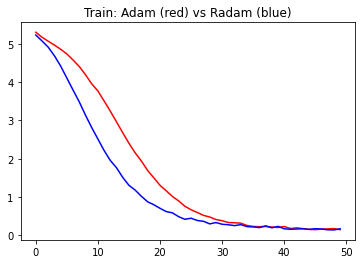

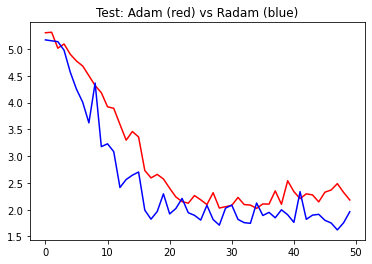

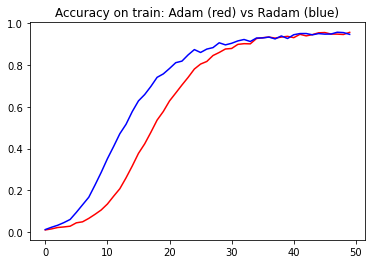

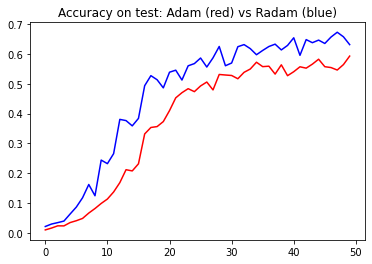

In [47]:
def main():
    solver = Solver()
    solver.train()
    # solver.test()


def graphics():
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []
    with open('./drive/MyDrive/Colab_Notebooks/densenet121_adam_epoch_res.txt', 'r') as f:
        for i in range(50):
            line = f.readline()
            train_loss.append(float(line[12:18]))
            train_acc.append(float(line[25:31]))
            line = f.readline()
            test_loss.append(float(line[11:17]))
            test_acc.append(float(line[24:30]))
    
    train_loss_r = []
    train_acc_r = []
    test_loss_r = []
    test_acc_r = []
    with open('./drive/MyDrive/Colab_Notebooks/densenet121_radam_epoch_res.txt', 'r') as f:
        for i in range(50):
            line = f.readline()
            train_loss_r.append(float(line[12:18]))
            train_acc_r.append(float(line[25:31]))
            line = f.readline()
            test_loss_r.append(float(line[11:17]))
            test_acc_r.append(float(line[24:30]))
    
    plt.plot(train_loss, color='red')
    plt.plot(train_loss_r, color='blue')
    plt.title("Train: Adam (red) vs Radam (blue)")
    plt.show()

    plt.plot(test_loss, color='red')
    plt.plot(test_loss_r, color='blue')
    plt.title("Test: Adam (red) vs Radam (blue)")
    plt.show()

    plt.plot(train_acc, color='red')
    plt.plot(train_acc_r, color='blue')
    plt.title("Accuracy on train: Adam (red) vs Radam (blue)")
    plt.show()

    plt.plot(test_acc, color='red')
    plt.plot(test_acc_r, color='blue')
    plt.title("Accuracy on test: Adam (red) vs Radam (blue)")
    plt.show()

if __name__ == '__main__':
    # main()
    graphics()